In [ ]:
#######################################################################################
!pip install torch torchvision torchaudio --quiet
!pip install numpy pandas scikit-learn tqdm matplotlib --quiet
########################################################################################

!git clone https://github.com/HelenGuohx/logbert.git
%cd logbert


!ls


import sys
sys.path.append("/content/logbert")  # Add root folder to Python path


import torch
from bert_pytorch.model.log_model import BERTLog
from bert_pytorch.model.bert import BERT
import torch.nn as nn


vocab_size = 10000        # Total unique log keys in your dataset
max_len = 128             # Sequence length
hidden = 768              # Hidden size
n_layers = 12             # Transformer blocks
attn_heads = 12           # Attention heads
dropout = 0.3
is_logkey = True
is_time = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


bert_model = BERT(
    vocab_size=vocab_size,
    max_len=max_len,
    hidden=hidden,
    n_layers=n_layers,
    attn_heads=attn_heads,
    dropout=dropout,
    is_logkey=is_logkey,
    is_time=is_time
).to(device)


class BERTLog(nn.Module):
    def __init__(self, bert, vocab_size):
        super().__init__()
        self.bert = bert
        self.logkey_predictor = nn.Linear(bert.hidden, vocab_size)
        if self.bert.is_time:
            self.time_predictor = nn.Linear(bert.hidden, bert.max_len) # Example output size, adjust as needed
        else:
            self.time_predictor = None

        # Add classification heads if they exist in your original model structure
        if hasattr(bert, 'cls_head'):
             self.cls_head = bert.cls_head
        if hasattr(bert, 'cls_fnn'):
            self.cls_fnn = bert.cls_fnn


    def forward(self, x, time_info=None):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        encoded_layers = self.bert(x, time_info, mask) # Original forward pass

        logkey_output = self.logkey_predictor(encoded_layers)
        time_output = None
        if self.time_predictor:
            time_output = self.time_predictor(encoded_layers)

        # Include classification head outputs if available
        cls_output = None
        if hasattr(self, 'cls_head'):
            cls_output = self.cls_head(encoded_layers[:, 0]) # Assuming CLS token at index 0

        cls_fnn_output = None
        if hasattr(self, 'cls_fnn'):
            cls_fnn_output = self.cls_fnn(encoded_layers[:, 0]) # Assuming CLS token at index 0


        return {'logkey_output': logkey_output,
                'time_output': time_output,
                'cls_output': cls_output,
                'cls_fnn_output': cls_fnn_output}

    def forward_from_embedding(self, x_emb, time_info=None):

        dummy_x = torch.ones(x_emb.shape[0], x_emb.shape[1], dtype=torch.long, device=x_emb.device) # Dummy input for mask
        mask = (dummy_x > 0).unsqueeze(1).repeat(1, dummy_x.size(1), 1).unsqueeze(1)


        pass # Reverting this method

fatal: destination path 'logbert' already exists and is not an empty directory.
/content/logbert
bert_pytorch  environment  img	    logdeep   logparser  README.md  TBird
BGL	      HDFS	   LICENSE  loglizer  Pipfile	 scripts
Using device: cpu


In [ ]:
import pandas as pd
import json

# Replace with your JSON path
test_path = "/content/3.2_test.json"

# Read file line by line and parse each as a JSON object
data = []
with open(test_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Skipping malformed line due to JSONDecodeError: {e} - Line: {line}")
                continue

test_df = pd.DataFrame(data)
print(test_df.head())

Skipping malformed line due to JSONDecodeError: Expecting value: line 1 column 1 (char 0) - Line: sequence_id": 277106, "label": [-1, 1, 1, 1, 1], "error_anomaly": false, "numeric_sequence": [[9, 145506, 3, 4, 5, 6, 7, 114, 9, 11, 9, 13, 14, 13, 13, 13, 46, 13, 13, 11, 13, 12, 1643, 1080, 278, 9, 515, 9, 4763, 9, 20, 21, 352335, 5022, 9, 2065, 244, 136591, 245, 4, 9, 7144, 31, 9, 9, 9, 9], [9, 143501, 3, 4, 105151, 6, 70, 9, 9, 668, 9, 9, 12, 9, 11, 13, 13, 13, 13, 12, 13, 13, 13, 13, 12, 519, 231268, 1370, 9, 312, 9, 263, 9, 20, 21, 352336, 2169, 9, 5044, 105151, 136591, 333, 105151, 130529, 20, 4, 18439, 13, 18439, 484, 131165, 9, 21712, 31, 9, 9, 9], [9, 143501, 3, 4, 105151, 6, 70, 9, 9, 668, 9, 9, 12, 9, 11, 13, 13, 13, 13, 12, 13, 13, 13, 13, 12, 519, 231268, 1370, 9, 312, 9, 263, 9, 20, 21, 352336, 2169, 9, 5044, 105151, 136591, 78, 105151, 130529, 20, 4, 18439, 13, 18439, 484, 41006, 9, 21712, 31, 9, 9, 9], [9, 143501, 3, 4, 105151, 6, 70, 9, 9, 668, 9, 9, 12, 9, 11, 13, 13, 13

In [ ]:
# Keep sequences as a list (no need to convert to NumPy array)
test_samples = test_df['numeric_sequence'].tolist()[:50]

# Check length of first 5 sequences
for i, seq in enumerate(test_samples[:5]):
    print(f"Sample {i} length: {len(seq)}")


Sample 0 length: 5
Sample 1 length: 2
Sample 2 length: 3
Sample 3 length: 2
Sample 4 length: 5


In [ ]:
import torch
import numpy as np

# Assuming you have your trained LogBERT model
# model = ... (your trained LogBERT)
# tokenizer = ... (if needed for mapping)

def logbert_predict(sequences):
    """
    sequences: list of numeric sequences (list of ints)
    returns: np.array of prediction probabilities
    """
    model.eval()
    outputs = []

    with torch.no_grad():
        for seq in sequences:
            # Convert to tensor and add batch dimension
            input_tensor = torch.tensor([seq], dtype=torch.long)  # shape: [1, seq_len]

            # Get model prediction (adjust depending on your model's output)
            logits = model(input_tensor)  # shape: [1, num_classes]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            outputs.append(probs[0])

    return np.array(outputs)


In [ ]:
# Example: fully flatten each sample
def flatten_nested(seq):
    flat = []
    for item in seq:
        if isinstance(item, list):
            flat.extend(flatten_nested(item))
        else:
            flat.append(item)
    return flat

# Apply to all test samples
flat_samples = [flatten_nested(seq) for seq in test_samples]

# Now pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in flat_samples)
padded_samples = pad_sequences(flat_samples, maxlen=max_len, padding='post', value=0)

print("Number of samples:", len(padded_samples))
print("Padded shape:", padded_samples.shape)
print("Example first sample:", padded_samples[0])


Number of samples: 50
Padded shape: (50, 23024)
Example first sample: [     9 124757      3 ...      0      0      0]


In [ ]:
from bert_pytorch.model.bert import BERT
from bert_pytorch.model.log_model import BERTLog


In [ ]:
from bert_pytorch.model.bert import BERT
import inspect

print(inspect.signature(BERT.__init__))


(self, vocab_size, max_len=512, hidden=768, n_layers=12, attn_heads=12, dropout=0.1, is_logkey=True, is_time=False)


#SHAP

Loaded label map with 13214 labels.
Number of sequences: 2644, sequence length: 72
Model loaded successfully with 2644 sequences.


PermutationExplainer explainer: 100%|██████████| 100/100 [08:41<00:00,  4.83s/it]
PermutationExplainer explainer: 101it [08:46,  5.31s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [08:33<00:00,  5.86s/it]
PermutationExplainer explainer: 101it [08:37,  5.23s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [09:03<00:00,  5.39s/it]
PermutationExplainer explainer: 101it [09:10,  5.56s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [08:51<00:00,  5.73s/it]
PermutationExplainer explainer: 101it [08:57,  5.48s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [09:34<00:00,  6.00s/it]
PermutationExplainer explainer: 101it [09:39,  5.85s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [09:17<00:00,  5.64s/it]
PermutationExplainer explainer: 101it [09:21,  5.67s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [08:56<00:00,  5.27s/it]
PermutationExplainer explainer: 101it [09:01,  5.52s/it]
PermutationExplainer explai

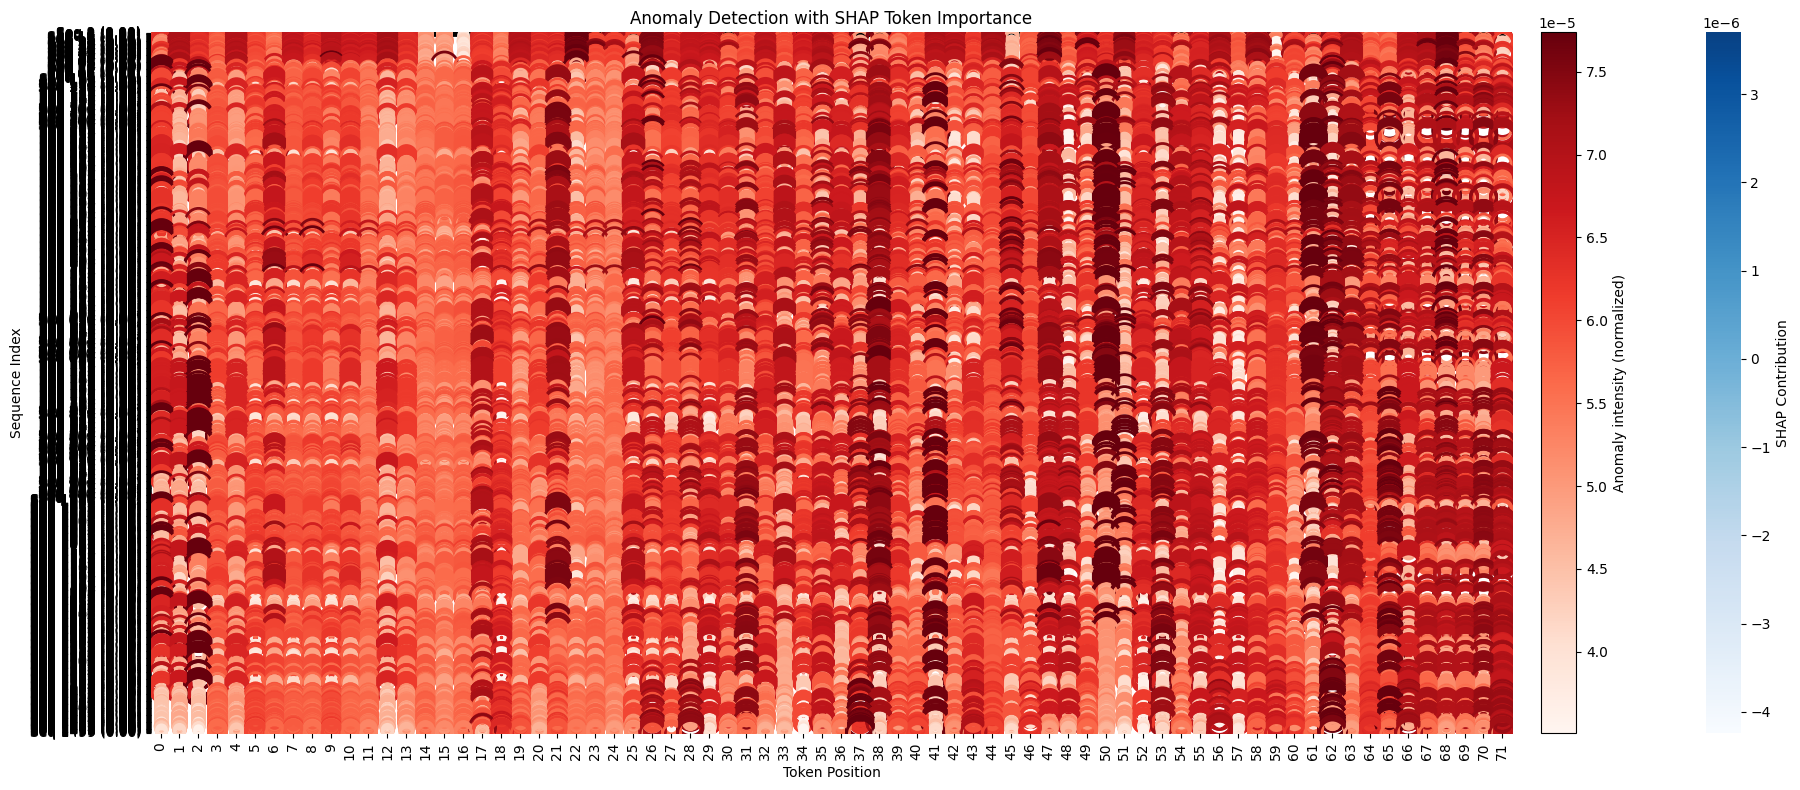

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.patches import Rectangle
import json
from tqdm import tqdm # Added import for tqdm

# -----------------------------
# 1️⃣ File paths
# -----------------------------
MODEL_PATH = "/content/Hmodel_final.pt"
TOKENIZED_INPUTS = "/content/tokenized_inputs.npz"
LABEL_MAP_PATH = "/content/label_map.json"
PAD_ID = 0

# -----------------------------
# 2️⃣ Load label map
# -----------------------------
with open(LABEL_MAP_PATH, "r") as f:
    label_map = json.load(f)
print(f"Loaded label map with {len(label_map)} labels.")

# -----------------------------
# 3️⃣ Load tokenized inputs
# -----------------------------
data_np = np.load(TOKENIZED_INPUTS, allow_pickle=True)
features_np = data_np["tokenized_inputs"]  # shape: (num_sequences, seq_len)
num_sequences, seq_len = features_np.shape
print(f"Number of sequences: {num_sequences}, sequence length: {seq_len}")

# -----------------------------
# 4️⃣ Load model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example model class (replace with your actual model definition)
class BERTLog(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        # Minimal placeholder
        self.embedding = torch.nn.Embedding(config["vocab_size"], config["hidden"])
        self.output = torch.nn.Linear(config["hidden"], len(label_map))
    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        return self.output(x)

# Example config
config = {
    "vocab_size": 100000,
    "hidden": 240
}

model = BERTLog(config).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.eval()
print(f"Model loaded successfully with {num_sequences} sequences.")

# -----------------------------
# 5️⃣ Use a subset for SHAP (memory safe)
# -----------------------------
import shap

subset_size = min(1500, num_sequences)  # up to 3000 sequences
batch_size = 100  # batch size for SHAP to avoid memory crash

norm_shap_seq = []
heatmap_matrix = []
anomaly_scores = []

# Wrap model for SHAP (returns probabilities)
def model_wrapper(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.long, device=device)
        out = model(x_tensor)
        return torch.softmax(out, dim=-1).cpu().numpy()

# Process in batches
for start in tqdm(range(0, subset_size, batch_size), desc="Computing SHAP in batches"):
    end = min(start + batch_size, subset_size)
    batch_features = features_np[start:end]
    batch_features_tensor = torch.tensor(batch_features, dtype=torch.long, device=device)

    # Background for SHAP
    background = batch_features_tensor[:50].cpu().numpy()
    explainer = shap.Explainer(model_wrapper, background)

    shap_values_batch = explainer(batch_features_tensor.cpu().numpy()).values

    for i in range(end - start):
        seq_ids = batch_features[i]
        mask_real = seq_ids != PAD_ID
        pred_class = np.argmax(model_wrapper(seq_ids[np.newaxis, :]), axis=1)[0]
        shap_vals = shap_values_batch[i, :, pred_class]
        heatmap_matrix.append(shap_vals[mask_real])

        # Normalize per sequence
        real_vals = shap_vals[mask_real]
        if np.any(real_vals):
            norm_vals = (real_vals - real_vals.min()) / (real_vals.max() - real_vals.min() + 1e-8)
        else:
            norm_vals = real_vals
        norm_shap_seq.append(norm_vals)

        # Compute anomaly score
        anomaly_scores.append(np.sum(np.abs(shap_vals)))

# Convert lists to arrays
max_len_seq = max(len(seq) for seq in heatmap_matrix)
heatmap_matrix_padded = np.array([np.pad(seq, (0, max_len_seq - len(seq)), 'constant')
                                  for seq in heatmap_matrix])
heatmap_matrix = heatmap_matrix_padded
norm_shap_seq_padded = np.array([np.pad(seq, (0, max_len_seq - len(seq)), 'constant')
                                 for seq in norm_shap_seq])
norm_shap_seq = norm_shap_seq_padded

anomaly_scores = np.array(anomaly_scores)
norm_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-8)

# -----------------------------
# 6️⃣ Sort sequences by anomaly score
# -----------------------------
sorted_indices = np.argsort(anomaly_scores)[::-1]
heatmap_matrix_sorted = heatmap_matrix[sorted_indices]
norm_shap_sorted = norm_shap_seq[sorted_indices]
anomaly_scores_sorted = anomaly_scores[sorted_indices]
norm_scores_sorted = norm_scores[sorted_indices]

# -----------------------------
# 7️⃣ Plot heatmap (same as before)
# -----------------------------
fig, ax0 = plt.subplots(figsize=(20, 8))
sns.heatmap(
    heatmap_matrix_sorted,
    cmap="Blues",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Contribution'},
    ax=ax0
)

# Add red circles
min_marker, max_marker = 5, 20
num_sequences, seq_len = heatmap_matrix_sorted.shape
from matplotlib import cm
from matplotlib.patches import Rectangle

for i in range(num_sequences):
    for j in range(seq_len):
        if heatmap_matrix_sorted[i, j] != 0:
            color_intensity = norm_shap_sorted[i, j]
            size = min_marker + color_intensity * (max_marker - min_marker)
            ax0.plot(j + 0.5, i + 0.5, marker='o', markersize=size,
                     markerfacecolor='none',
                     markeredgecolor=cm.Reds(color_intensity),
                     markeredgewidth=2)

# Rightmost anomaly column
red_column = norm_scores_sorted[:, np.newaxis]
ax0.imshow(red_column, cmap='Reds', aspect='auto', extent=[seq_len, seq_len+1, 0, num_sequences])

# Y-axis labels
seq_labels = [f"Seq {i} ({anomaly_scores_sorted[i]:.2f})" for i in range(num_sequences)]
ax0.set_yticks(np.arange(num_sequences) + 0.5)
ax0.set_yticklabels(seq_labels, fontsize=10)

ax0.set_xlabel("Token Position")
ax0.set_ylabel("Sequence Index")
ax0.set_title("Anomaly Detection with SHAP Token Importance")

# Highlight top 5 sequences
top_n = min(5, num_sequences)
for i in range(top_n):
    ax0.add_patch(Rectangle(
        (0, i), seq_len+1, 1, fill=False, edgecolor='black', linewidth=2
    ))

# Colorbar
sm = cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=anomaly_scores.min(), vmax=anomaly_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, fraction=0.05, pad=0.02)
cbar.set_label("Anomaly intensity (normalized)")

plt.tight_layout()
plt.show()

#LLM


In [ ]:
!pip install transformers accelerate --quiet


In [ ]:
# -----------------------------
# Memory-efficient LLM setup
# -----------------------------
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Use smaller model for Colab memory
llm_model_name = "bigscience/bloom-560m"  # <2GB VRAM
tokenizer_llm = AutoTokenizer.from_pretrained(llm_model_name)
model_llm = AutoModelForCausalLM.from_pretrained(llm_model_name, device_map="auto")
text_gen = pipeline("text-generation", model=model_llm, tokenizer=tokenizer_llm)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Device set to use cpu


In [31]:
# ==============================
# Improved LLM-based anomaly explanations (fixed)
# ==============================
# Model config reference:
# {"vocab_size": 100000, "max_len": 72, "hidden": 240,
#  "n_layers": 7, "attn_heads": 8, "dropout": 0.3,
#  "batch_size": 64, "lr": 2e-05, "epochs": 10}

import json
import numpy as np
import os

# -----------------------------
# 1️⃣ Load tokenizer.json
# -----------------------------
TOKENIZER_PATH = "/content/tokenizer.json"
with open(TOKENIZER_PATH, "r") as f:
    token2idx = json.load(f)
idx2token = {v: k for k, v in token2idx.items()}

# -----------------------------
# 2️⃣ TOKEN_INFO explanations (UPDATED)
# -----------------------------
TOKEN_INFO = {
    # ---------------------------
    # System / Workflow Anomalies
    # ---------------------------
    "S": ("system", "its behavior violates expected patterns"),
    "Y": ("system_yield", "wait duration exceeds normal limits"),
    "y": ("yield", "resource usage interrupts workflow"),
    "w": ("workflow", "operation sequence deviates from specification"),
    "P": ("process", "unexpected process identifier appeared"),
    "v": ("variable", "value changed outside expected range"),
    "b": ("buffer", "memory usage exceeds safe thresholds"),
    "f": ("flag", "state is inconsistent with configuration"),
    "N": ("node", "node behavior deviates from cluster rules"),
    "h": ("heartbeat", "signal frequency breaks system baseline"),

    # ---------------------------
    # User / Authentication / Access
    # ---------------------------
    "u": ("user", "activity violates access patterns"),
    "l": ("login", "multiple failures occurred in short time"),
    "a": ("access", "resource usage violates permissions"),

    # ---------------------------
    # Network / Communication
    # ---------------------------
    "T": ("TCP", "connection sequence is irregular"),
    "I": ("ICMP", "packet frequency or pattern deviates from baseline"),
    "p": ("packet", "size or timing breaks protocol norms"),
    "g": ("gateway", "traffic violates routing rules"),

    # ---------------------------
    # Input / Output / Command
    # ---------------------------
    "i": ("input", "value format is invalid"),
    "d": ("data", "content structure is corrupted"),
    "o": ("output", "results deviate from expected pattern"),
    "c": ("command", "operation is unauthorized"),
    "x": ("execution", "code path is irregular"),
    "M": ("commit", "duplicate operations occurred"),
    "m": ("malware", "activity matches known malicious patterns"),
    "r": ("request", "sequence violates expected protocol"),
    "q": ("query", "pattern breaks normal database rules"),
    "t": ("token", "value is inconsistent or corrupted"),

    # ---------------------------
    # Parsing / Formatting / Tokens
    # ---------------------------
    "<PAD>": ("padding", "placeholder indicates missing input"),
    " ": ("space", "unexpected separator breaks parsing"),
    ",": ("comma", "punctuation placement violates log format"),
    ";": ("delimiter", "formatting rules are violated"),
    ":": ("kv_sep", "entry structure is malformed"),
    "/": ("path_sep", "traversal rules are broken"),
    "→": ("transition", "state change violates flow control"),

    # ---------------------------
    # Numeric / Sequence Indicators
    # ---------------------------
    "1": ("digit1", "appears in unexpected position"),
    "2": ("digit2", "deviates from sequence"),
    "3": ("digit3", "occurs in improper stage"),
    "4": ("digit4", "value exceeds expected range"),
    "5": ("digit5", "sequence context is irregular"),
    "6": ("digit6", "progression is broken"),
    "7": ("digit7", "position violates expected order"),
    "8": ("digit8", "pattern is uncommon"),
    "9": ("digit9", "metric count is unexpected"),

    # ---------------------------
    # Browser / Client / Misc
    # ---------------------------
    "C": ("Chrome", "user-agent is unexpected"),
    "E": ("error", "code or sequence deviates from baseline"),
}


# -----------------------------
# 3️⃣ Parameters (unchanged)
# -----------------------------
MIN_ANOMALOUS_TOKENS = 2
PAD_ID = token2idx["<PAD>"]

# -----------------------------
# 4️⃣ Output folder
# -----------------------------
os.makedirs("output", exist_ok=True)
OUTPUT_FILE = "/content/03_LLM_anomaly_explanations.txt"

# -----------------------------
# 5️⃣ Compute dynamic SHAP threshold
# -----------------------------
all_shap_values = norm_shap_seq.flatten()
SHAP_THRESHOLD = np.percentile(np.abs(all_shap_values), 98.2)
print(f"Dynamic SHAP threshold: {SHAP_THRESHOLD:.4f}")

# -----------------------------
# 6️⃣ Loop over sequences
# -----------------------------
num_sequences = norm_shap_seq.shape[0]

with open(OUTPUT_FILE, "w") as fout:
    for i in range(num_sequences):
        sample_ids = features_np[i]
        shap_vals = norm_shap_seq[i]

        anomalous_tokens = [
            (TOKEN_INFO.get(idx2token[tok_id], ("unknown", "rarely appears"))[0],
             TOKEN_INFO.get(idx2token[tok_id], ("unknown", "rarely appears"))[1],
             float(shap_vals[pos]))
            for pos, tok_id in enumerate(sample_ids)
            if tok_id != PAD_ID and abs(shap_vals[pos]) >= SHAP_THRESHOLD
        ]

        seen_tokens = set()
        top_tokens = []
        for t in sorted(anomalous_tokens, key=lambda x: x[2], reverse=True):
            if t[0] not in seen_tokens and t[2] > 0:
                top_tokens.append(t)
                seen_tokens.add(t[0])
            if len(top_tokens) == 7:
                break

        label = "Anomalous" if len(top_tokens) >= MIN_ANOMALOUS_TOKENS else "Normal"

        header = f"\n--- Sequence {i} ---\n{label}\n"
        print(header)
        fout.write(header + "\n")

        if label == "Anomalous":
            token_line = "Top anomalous tokens (name, SHAP): " + str(
                [(t[0], round(t[2], 4)) for t in top_tokens]
            )
            print(token_line)
            fout.write(token_line + "\n\n")

            explanation_text = "\n".join(
                [f"- Token: \"{t[0]}\" - {t[1]}" for t in top_tokens]
            )

            print("LLM Explanation:\n")
            print(explanation_text + "\n")

            fout.write("LLM Explanation:\n")
            fout.write(explanation_text + "\n\n")

print(f"All explanations saved to {OUTPUT_FILE}")


Dynamic SHAP threshold: 0.9746

--- Sequence 0 ---
Normal


--- Sequence 1 ---
Anomalous

Top anomalous tokens (name, SHAP): [('output', 0.9972), ('space', 0.989)]
LLM Explanation:

- Token: "output" - results deviate from expected pattern
- Token: "space" - unexpected separator breaks parsing


--- Sequence 2 ---
Normal


--- Sequence 3 ---
Anomalous

Top anomalous tokens (name, SHAP): [('yield', 0.9984), ('space', 0.9888)]
LLM Explanation:

- Token: "yield" - resource usage interrupts workflow
- Token: "space" - unexpected separator breaks parsing


--- Sequence 4 ---
Normal


--- Sequence 5 ---
Normal


--- Sequence 6 ---
Normal


--- Sequence 7 ---
Normal


--- Sequence 8 ---
Normal


--- Sequence 9 ---
Normal


--- Sequence 10 ---
Normal


--- Sequence 11 ---
Normal


--- Sequence 12 ---
Normal


--- Sequence 13 ---
Normal


--- Sequence 14 ---
Anomalous

Top anomalous tokens (name, SHAP): [('output', 0.9971), ('space', 0.989)]
LLM Explanation:

- Token: "output" - results deviate